In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
pd.set_option('display.max_rows', None)

# analyze_tau version that only applies tau correction to core range (but, includes all points in optimization)
# (cleaned-up version of 3-region analyze_tau script, also using slope tau optimization)

In [2]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata


In [3]:
#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']

In [4]:
# Read in the CSV files (full-width, then the 3 different regions)

#get the full-width image data
full_img_filepath = '../data_files/ew_stats_139470_140120_140320_140965_0.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [5]:
#print initial statistics
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()


** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

../data_files/ew_stats_139470_140120_140320_140965_0.csv



In [6]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
obsdata = remove_outliers(removed_eqx_obsdata, outliers)

Removed EQX OBSIDs: {'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_112RF_FMOVIE002_PRIME_1'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 142



In [18]:
ewi_hg_params, ewi_hg_used_data, ewi_hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EWI', None),
                                                                 verbose=False)
print()
print('Inner H-G params:')
print_hg_params(ewi_hg_params, indent=2)
print(f'  Standard deviation: {ewi_hg_std:.5f}')

ewc_hg_params, ewc_hg_used_data, ewc_hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EWC', 0.042),
                                                                 verbose=False)
print()
print('Core H-G params:')
print_hg_params(ewc_hg_params, indent=2)
print(f'  Standard deviation: {ewc_hg_std:.5f}')

ewo_hg_params, ewo_hg_used_data, ewo_hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EWO', None),
                                                                 verbose=False)
print()
print('Outer H-G params:')
print_hg_params(ewo_hg_params, indent=2)
print(f'  Standard deviation: {ewo_hg_std:.5f}')



Inner H-G params:
  g1 =  0.634 / scale1 =  0.502 / weight1 = 0.797
  g2 = -0.182 / scale2 =  0.128 / weight2 = 0.203
  Standard deviation: 0.11578

Core H-G params:
  g1 =  0.626 / scale1 =  1.156 / weight1 = 0.605
  g2 =  0.040 / scale2 =  0.755 / weight2 = 0.395
  Standard deviation: 0.06427

Outer H-G params:
  g1 =  0.998 / scale1 = 13.003 / weight1 = 0.987
  g2 =  0.222 / scale2 =  0.172 / weight2 = 0.013
  Standard deviation: 0.23729


Text(0.5, 1.0, 'Normal EW vs. Phase Angle (inner/core/outer)')

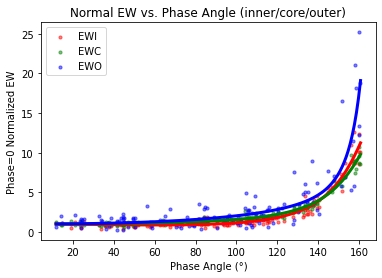

In [37]:
# Plot results
# plt.figure(figsize=(12,9)) 
# plt.subplot(3, 1, 1)
plt.scatter(obsdata['Mean Phase'], obsdata['Normal EWI']/hg_func(ewi_hg_params, 0), s=10, c='red', alpha=0.5, label='EWI')
plt.scatter(obsdata['Mean Phase'], compute_corrected_ew_col(obsdata, ('Normal EWC', 0.042))/hg_func(ewc_hg_params, 0), s=10, c='green', alpha=0.5, label='EWC')
plt.scatter(obsdata['Mean Phase'], obsdata['Normal EWO']/hg_func(ewo_hg_params, 0), s=10, c='blue', alpha=0.5, label='EWO')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
ewi_phase_model = hg_func(ewi_hg_params, xrange)/hg_func(ewi_hg_params, 0)
plt.plot(xrange, ewi_phase_model, '-', color='red', lw=3)
ewc_phase_model = hg_func(ewc_hg_params, xrange)/hg_func(ewc_hg_params, 0)
plt.plot(xrange, ewc_phase_model, '-', color='green', lw=3)
ewo_phase_model = hg_func(ewo_hg_params, xrange)/hg_func(ewo_hg_params, 0)
plt.plot(xrange, ewo_phase_model, '-', color='blue', lw=3)


plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Phase=0 Normalized EW')
plt.title('Normal EW vs. Phase Angle (inner/core/outer)')